In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


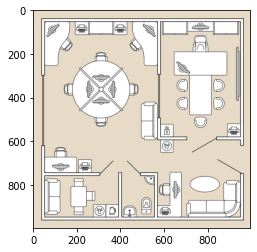

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("image.jpg")
plt.imshow(image)
plt.show()

In [3]:
# photo into grid 
env=image 

In [4]:
import numpy as np  # for array stuff and random
from PIL import Image  # for creating visual of our env
import cv2  # for showing our visual live
import matplotlib.pyplot as plt  # for graphing our mean rewards over time
import pickle  # to save/load Q-Tables
from matplotlib import style  # to make pretty charts because it matters.
import time  # using this to keep track of our saved Q-Tables.

style.use("ggplot")  # setting our style!

In [5]:
SIZE = 10

In [6]:
HM_EPISODES = 25000
mediumSNR_PENALTY = 10  # feel free to tinker with these!
lowSNR_PENALTY = 40  # feel free to tinker with these!
highSNR_REWARD = 25  # feel free to tinker with these!

epsilon = 0.5  # randomness
EPS_DECAY = 0.9999  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 1000  # how often to play through env visually.

start_q_table = None  # if we have a pickled Q table, we'll put the filename of it here.

LEARNING_RATE = 0.1
DISCOUNT = 0.95

ANTENNA_N = 1  # player key in dict

# the dict! Using just for colors
d = {1: (255, 175, 0) }  # Antenna color blue
#SNR RANGES 
snr_range={"highSNR_max":-50,"highSNR_min":-80,
           "mediumSNR_max":-90,"mediumSNR_min":-100,
          "deadzone":-120}

In [7]:
#antenna 
class antenna:
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)
    def __str__(self):
        return f"{self.x}, {self.y}"
    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)
    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3)
        '''
        if choice == 0:  #up
            self.move(x=0, y=1)
        elif choice == 1:  #down  
            self.move(x=0, y=-1)
        elif choice == 2:  #left  
            self.move(x=-1, y=0)
        elif choice == 3:    #right 
            self.move(x=1, y=0)
            
    def move(self, x=False, y=False):
        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y


        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1
        

In [8]:
ant = antenna()
print(ant)
ant.action(2)
print(ant)

2, 3
1, 4


In [9]:
rows=4  #actions
cols=25 #states
q_table =np.zeros((rows,cols)) 
#print(q_table.shape)

In [10]:
def measureSNR ():
    x=input("please enter snr ? ")
    return x

In [11]:
def calSNRlow(grid):
    counter =0
    for i in range(1,len(grid)):
        if int(grid[i]) < snr_range["deadzone"]:
            counter+=1
    percent=counter*100/len(grid)
    return percent

In [12]:
episode_rewards = []
reward=0
for episode in range(HM_EPISODES):
    ant = antenna()
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False

    episode_reward = 0
    state=0
    for i in range(200):
        if np.random.random() > epsilon:
            # GET THE ACTION
            if state <=25:
                state=0
            else:
                state+=1
            action = np.argmax(q_table[state])
        else:
            action = np.random.randint(0, 4)
        # Take the action!
        ant.action(action)
        ###
        #calculate the SNR 
        snr=measureSNR()
        percent=calSNRlow(snr)
        ##
        if percent > 20:
            reward-=10
        else:
            reward+=0
          ###
        current_q = q_table[state][action]
        max_future_q = np.max(q_table[state])
        new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[state][action] = new_q


        episode_reward += reward
            
    #print(episode_reward)
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY


C:\Users\Shiko\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shiko\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on #0, epsilon is 0.5
1000 ep mean: nan
please enter snr ? [-80,-50,-20,-120,-140,-50,-80,-50,-20,-120,-140,-50,-80,-50,-20,-120,-140,-50,-80,-50,-20,-120,-140,-50,-66,-24,-150]]


ValueError: invalid literal for int() with base 10: '-'

In [ ]:
if snr >snr_range["highSNR_min"]:
    reward+= highSNR_REWARD
elif snr < snr_range["mediumSNR_max"] and  snr > snr_range["mediumSNR_min"]:
    reward+= mediumSNR_PENALTY
elif snr < snr_range["deadzone"]:
    reward-=lowSNR_PENALTY